<a href="https://colab.research.google.com/github/erikcah18/Disease-Prediction-from-Symptoms/blob/master/svm_dan_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SVM Classification Report:
              precision    recall  f1-score   support

     negatif       0.95      0.99      0.97       405
      netral       0.86      0.86      0.86       205
     positif       0.94      0.82      0.88       144

    accuracy                           0.92       754
   macro avg       0.92      0.89      0.90       754
weighted avg       0.92      0.92      0.92       754

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.5190 - loss: 1.0114 - val_accuracy: 0.7396 - val_loss: 0.6943
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.7477 - loss: 0.6276 - val_accuracy: 0.8723 - val_loss: 0.3386
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9131 - loss: 0.2535 - val_accuracy: 0.9204 - val_loss: 0.2513
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9678 - loss: 0.1210 - val_accuracy: 0.9204 - val_loss: 0.2412
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.9865 - loss: 0.0530 - val_accuracy: 0.9270 - val_loss: 0.2212
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

     negatif       0.97      0.97      0.97       405
      netral       0.82      0.90      0.86       205
     positif       0.93      0.81      0.86       144

    accuracy                           0.92       754
   macro avg       0.91      0.89      0

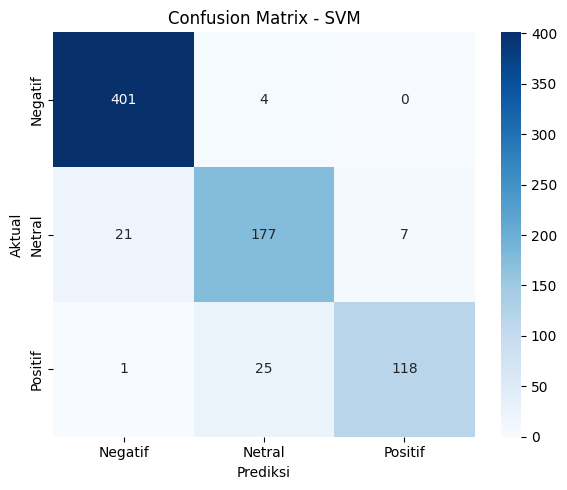

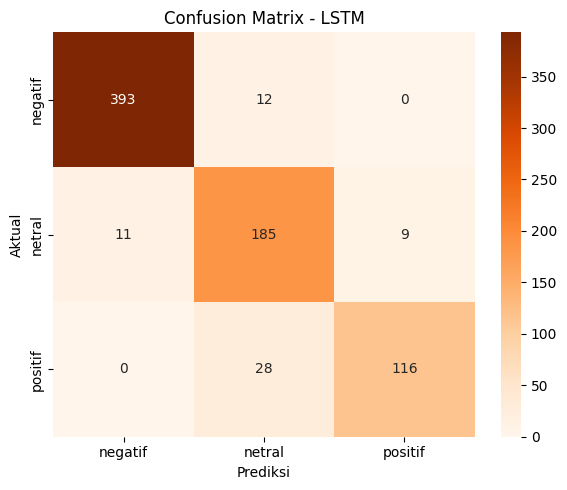

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import joblib

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# ============================
# 1. Load Dataset
# ============================
df = pd.read_csv("cobadata.csv")

# ============================
# 2. Lexicon-based Sentiment Labeling
# ============================
positive_words = [
    'bagus', 'baget', 'luar biasa', 'mantap', 'baik', 'cepat', 'mudah', 'suka',
    'keren', 'top', 'mantul', 'terbaik', 'ok', 'sangat bagus', 'membantu',
    'mantap', 'work', 'berhasil', 'sukses', 'lancar'
]

negative_words = [
    'lemot', 'buruk', 'jelek', 'lambat', 'susah', 'error', 'crash', 'macet',
    'hang', 'tidak bisa', 'kecewa', 'tidak dapat', 'tdk bisa', 'gagal',
    'tidak jalan', 'masalah', 'rusak', 'tidak berfungsi', 'jelek banget'
]

def lexicon_sentiment_analysis(text):
    text = str(text).lower()
    pos_count = sum(word in text for word in positive_words)
    neg_count = sum(word in text for word in negative_words)
    if pos_count > neg_count:
        return 'positif'
    elif neg_count > pos_count:
        return 'negatif'
    else:
        return 'netral'

df['sentimen'] = df['komentar'].apply(lexicon_sentiment_analysis)

# ============================
# 3. TF-IDF + SVM Pipeline
# ============================
X = df['komentar']
y = df['sentimen']
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(X)

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

model_svm = LinearSVC()
model_svm.fit(X_train_svm, y_train_svm)

y_pred_svm = model_svm.predict(X_test_svm)
print("SVM Classification Report:")
print(classification_report(y_test_svm, y_pred_svm))

conf_matrix_svm = confusion_matrix(y_test_svm, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negatif', 'Netral', 'Positif'],
            yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix - SVM")
plt.tight_layout()
plt.savefig("confusion_matrix_svm.png")

# ============================
# 4. LSTM Pipeline
# ============================
# Encode label
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Tokenisasi dan Padding
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded = pad_sequences(sequences, maxlen=100)

# Split data
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(padded, y_encoded, test_size=0.2, random_state=42)

# Bangun model LSTM
model_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=100),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 kelas: negatif, netral, positif
])

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Latih model
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=32, validation_split=0.2)

# Evaluasi
y_pred_lstm = model_lstm.predict(X_test_lstm)
y_pred_lstm_labels = y_pred_lstm.argmax(axis=1)

print("LSTM Classification Report:")
print(classification_report(y_test_lstm, y_pred_lstm_labels, target_names=label_encoder.classes_))

conf_matrix_lstm = confusion_matrix(y_test_lstm, y_pred_lstm_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_lstm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix - LSTM")
plt.tight_layout()
plt.savefig("confusion_matrix_lstm.png")
